In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import string
import re
from pickle import load
from pickle import dump

from unicodedata import normalize
from numpy import array
import pandas as pd
import requests
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax

import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import optimizers

from nltk.translate.bleu_score import corpus_bleu

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs
 
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# Load dataset
filename = '/content/gdrive/MyDrive/deu-eng-30k.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(20):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[go] => [geh]
[hi] => [hallo]
[hi] => [gra gott]
[run] => [lauf]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[duck] => [kopf runter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hlf]
[stay] => [bleib]
[stop] => [stopp]
[stop] => [anhalten]
[wait] => [warte]
[wait] => [warte]
[begin] => [fang an]
[do it] => [mache es]
[do it] => [tue es]
[go on] => [mach weiter]


In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text
# Let’s define another function to split the text into English-German pairs separated by ‘\n’. We’ll then split these pairs into English sentences and German sentences respectively.
# split a text into sentences

def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

#We can now use these functions to read the text into an array in our desired format.

data = read_text('/content/gdrive/MyDrive/deu-eng-30k.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

print(data[0:175])

Go.	Geh.
Hi.	Hallo!
Hi.	Grá Gott!
Run!	Lauf!
Run.	Lauf!
Wow!	Potzdonner!
Wow!	Donnerwetter!
Duck!	Kopf runter!
Fire!	Feuer!
Help!	Hilfe!
Help!	Zu Hlf!
Stay.	Bleib!
Stop!	Sto


In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Gr\x81á Gott'],
       ...,
       ['I feel very sleepy', 'Ich f\x81hle mich sehr schl„frig'],
       ['I feel very strong', 'Ich f\x81hle mich sehr stark'],
       ['I feel worse today', 'Heute geht es mir schlechter']],
      dtype='<U72')

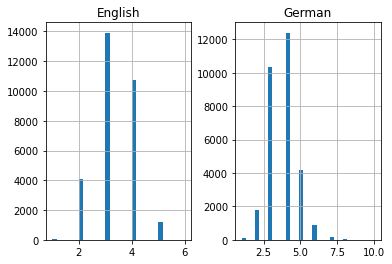

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'English':eng_l, 'German':deu_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')
 
# reduce dataset size to speed up training in demonstration
n_sentences = 30000
dataset = raw_dataset[:n_sentences, :]

# random shuffle
shuffle(dataset)

# split into train/test
ntest=dataset.shape[0]//6
train, test = dataset[:-ntest], dataset[-ntest:]
print(train.shape,test.shape)

# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

(25000, 2) (5000, 2)
Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


English Vocabulary Size: 4539
English Max Length: 6
German Vocabulary Size: 7204
German Max Length: 10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 512)           3688448   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 6, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 6, 512)            2099200   
                                                                 
 time_distributed (TimeDistr  (None, 6, 4539)          2328507   
 ibuted)                                                         
                   

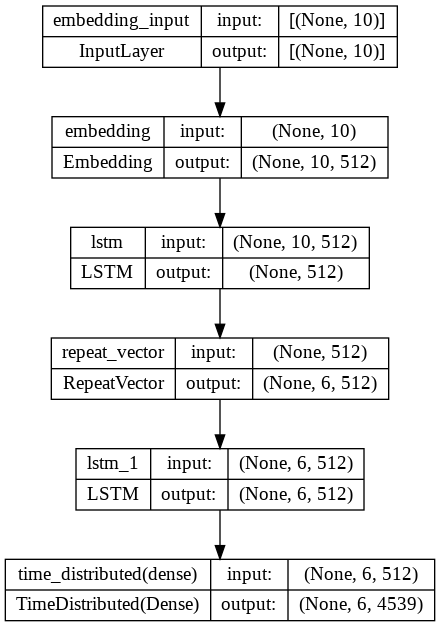

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
 
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
 
# Define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 512)

rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
 
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
 
# Define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 512)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
# Summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Fit model
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

filename = 'model.h4'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history= model.fit(trainX, trainY, epochs=45, batch_size=512, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

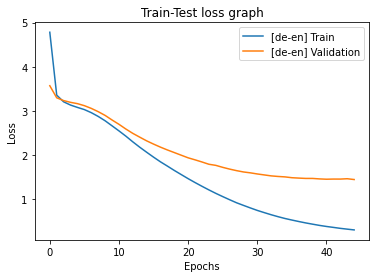

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train-Test loss graph')
plt.legend(['[de-en] Train','[de-en] Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

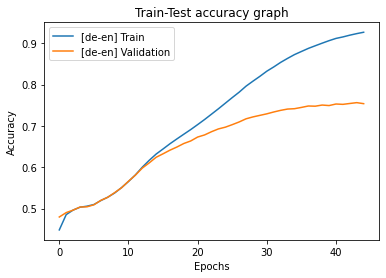

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train-Test accuracy graph')
plt.legend(['[de-en] Train','[de-en] Validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)
 
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
 
# load model
model = load_model('model.h4')
# test on some training sequences
print('******************** Train Result:********************')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('******************** Test Result:********************')
evaluate_model(model, eng_tokenizer, testX, test)

******************** Train Result:********************
src=[sie ruinierten es], target=[they ruined it], predicted=[they ruined it]
src=[ich bin auf der liste], target=[im on the list], predicted=[im on the list]
src=[tom hasst hunde], target=[tom hates dogs], predicted=[tom hates dogs]
src=[das gehrt tom], target=[it belongs to tom], predicted=[thats toms]
src=[mir ist in der tat kalt], target=[i sure am cold], predicted=[i am am cold]
src=[sie haben es mir versprochen], target=[you promised me], predicted=[you promised me]
src=[wirf eine mnze], target=[flip a coin], predicted=[flip a coin]
src=[verpetz mich nicht], target=[dont tell on me], predicted=[dont tell on me]
src=[golf ist langweilig], target=[golf is boring], predicted=[golf is boring]
src=[werft eine mnze], target=[flip a coin], predicted=[flip a coin]
BLEU-1: 0.906878
BLEU-2: 0.866260
BLEU-3: 0.822078
BLEU-4: 0.624272
******************** Test Result:********************
src=[sie liebt katzen], target=[she loves cats], pr

In [ ]:
#code for the reverse dictionary functionality
def find_words(eng_tokenizer, ger_tokenizer):    
    eng_words = determine_words(eng_tokenizer)
    ger_words = determine_words(ger_tokenizer)
            
    similar_words = [i[0] for i in model.most_similar(positive=eng_words, negative=ger_words, topn=10)]  

    words = []    

    for word in similar_words:
        if (word in dict_words):
            words.append(word)

    if (len(words) > 2):
        words = words[0:10]
    
    return words

In [ ]:
print('*********************Train Result:*********************')
pred_df = pd.DataFrame({'Source': train[:, 1], 'Actual':train[:, 0], 'Predicted':trainX[:, 1] })
pd.set_option('display.max_colwidth', 100)
pred_df.head(10)

*********************Train Result:*********************


,Source,Actual,Predicted
0,sie ruinierten es,they ruined it,4060
1,ich bin auf der liste,im on the list,12
2,tom hasst hunde,tom hates dogs,344
3,das gehrt tom,it belongs to tom,129
4,mir ist in der tat kalt,i sure am cold,3
5,sie haben es mir versprochen,you promised me,24
6,wirf eine mnze,flip a coin,31
7,verpetz mich nicht,dont tell on me,19
8,golf ist langweilig,golf is boring,3
9,werft eine mnze,flip a coin,31


In [ ]:
print('********************* Test Result:*********************')
pred_df = pd.DataFrame({'Source':test[:, 1], 'Actual':test[:, 0], 'Predicted':testX[:,1]})
pd.set_option('display.max_colwidth', 100)
pred_df.head(10)

********************* Test Result:*********************


,Source,Actual,Predicted
0,sie liebt katzen,she loves cats,158
1,siehst du eine rose,do you see a rose,8
2,tom ist nicht wie wir,tom isnt like us,3
3,niemand erinnert sich,nobody remembers,1863
4,ich bin die bse,im the bad one,12
5,tom kann uns helfen,tom can help us,22
6,schneide es in zwei teile,cut it in half,6
7,hast du einen blog,do you have a blog,8
8,er kam wohlbehalten an,he arrived safely,128
9,kann ich bitte eine tte haben,can i get a bag,2
